# Hypothesis testing
Auhtor: Artur Kalinowski

## Setup the environment

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np

#HEP specific tools
import scipy.constants as scipy_constants
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import gamma

#Plotting libraries
import matplotlib.pyplot as plt

#Functions manipulation
from functools import partial

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

### Interpretarion of a simple measuremnt: a toy MC

Consider a measuremnt of a pencil with a ruler with 0.1 cm markings. Assume the measuremnt result fluctuates accoring to the Gaussian distribution $N(\mu, \sigma)$. Take:

\begin{equation}
\mu = 15,~
\sigma = 0.1/\sqrt{12}
\end{equation}

## <span style='color:red'> Please: </span> 

* simulate 10000 measuremnts of the pensil length
* calculate the fraction of cases when the true value was within the coverage region: $[x - \sigma, x+\sigma]$

**Hints**:
* use `np.logical_and(l0>xMin, l0<xMax)`
* use `np.mean(...)


In [2]:
n = 10000
l0 = 15
sigma0 = 0.1/np.sqrt(12)

x = l0 + np.random.randn(n)*sigma0
xMin = x - sigma0
xMax = x + sigma0

isWithinRange = np.logical_and(l0>xMin, l0<xMax) 
fraction = np.mean(isWithinRange)

print(colored("Fraction of regions covering the true value is?:","blue"),fraction)

Fraction of regions covering the true value is?: 0.677


### Type I and Type II errors

Assume we have an experiment loking for a (the?) "new physics events". The are two competing models:
* $H_{0}$: **no new physics**, or **background only** hypothesis - we expect to obeserve `nBkg = 10` events
* $H_{1}$: **new physics**, or **signal** hypothesis - we expect to observe `nSgn = 2` events on top of background
* $D$: the experiment result is `n = 12`

Please:

* calculate the probability of osberving `n` or more events under $H_{0}$, and $H_{1}$
* assume we claim discovery, and reject $H_{0}$ - calculate $\alpha$
* assume we claim no observation of new physics, and not reject $H_{0}$ - calculate $\beta$ 

**Hint** use `poisson(mu).pmf(k)` from scpit.stats package

In [3]:
nBkg = 10
nSgn = 2
n = 12

p_H0 = poisson(nBkg).pmf(n)
p_H1 = poisson(nBkg+nSgn).pmf(n)

alpha = 1.0 - np.sum([poisson(nBkg).pmf(k) for k in range(0,n)])
beta = np.sum([poisson(nBkg+nSgn).pmf(k) for k in range(0,n+1)])

print(colored("p(n|H0) = ","blue"), "{:3.3f}".format(p_H0))
print(colored("p(n|H1) = ","blue"), "{:3.3f}".format(p_H1))
print(colored("Type I error:","blue"), "{:3.3f}".format(alpha))
print(colored("Type II error:","blue"), "{:3.3f}".format(beta))

p(n|H0) =  0.095
p(n|H1) =  0.114
Type I error: 0.303
Type II error: 0.576


### Type I and Type II errors - graphical representation

## <span style='color:red'> Please: </span> 

* plot $p(n|H_{0})$ and $p(n|H_{1})$
* fill areas showing the size of $\alpha$, and $\beta$
* make plots for `nBkg=10, nSgn=2, n=12` and `nBkg=20, nSgn=10, n=30` 

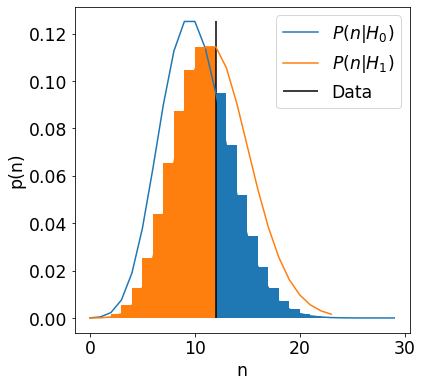

In [4]:
nBkg = 10
nSgn = 2
n = 12

p_H0 = [poisson(nBkg).pmf(k) for k in range(0,3*nBkg)]
p_H1 = [poisson(nBkg+nSgn).pmf(k) for k in range(0,2*(nBkg+nSgn))]

alpha = [(k>=n)*poisson(nBkg).pmf(k) for k in range(0,3*nBkg)]
beta = [(k<=n)*poisson(nBkg+nSgn).pmf(k) for k in range(0,2*(nBkg+nSgn))]

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(p_H0, label=r"$P(n|H_{0})$");
ax.plot(p_H1, label=r"$P(n|H_{1})$");
ax.fill_between(x=range(0,3*nBkg), y1=alpha, y2=0, step="post")
ax.fill_between(x=range(0,2*(nBkg+nSgn)), y1=beta, y2=0, step="pre")
ax.vlines(n, ymin=0, ymax=np.max(p_H0), colors='k', label="Data")
ax.set_xlabel("n")
ax.set_ylabel("p(n)")
ax.legend();

## Likelihood ratio for counting experiment

Prepare functions for calculating:

* `t(data, mu_H0, mu_H1)` - general statistics for hypothesis testing
* `q0(data, mu_H0, mu_H1)` - statistics for one sided (excess) B-obly hypothesis testing
* `generate_data_hist(nEvents, nIter, muData, muH0, bins, test_statistics)` - histograms of test statistics. This is in order not to keep a large number of tesst statistics values for individial events

In [5]:
############################################################
def t(data, mu_H0, mu_H1):
    result = -2.0*(np.log(poisson.pmf(data, mu_H0)) - np.log(poisson.pmf(data, mu_H1)))
    return result
############################################################
############################################################
def q0(data, mu_H0, mu_H1):
    result = -2.0*(np.log(poisson.pmf(data, mu_H0)) - np.log(poisson.pmf(data, mu_H1)))
    result = np.where(data<mu_H0, 0, result)  #discovery
    #result = np.where(data>mu_H0, 0, result) #exclusion
    return result
############################################################
def generate_data_hist(nEvents, nIter, muData, muH0, bins, test_statistics):
    
    result = np.zeros(bins.shape[0]-1)
    
    for iter in range(nIter):
        data = np.random.poisson(muData, nEvents)
        t = test_statistics(data, muH0, data)
        hist,_ = np.histogram(t, bins=bins)
        result +=hist
    return result 
############################################################

### Toy Monte Carlo data generation

* generate `nEvents` events with `muBkg=20`, `muSgn=10` 
* calculate the t values for each event
* create histograms of t with bins defined as `np.arange(0,40,0.5)`

In [6]:
%%time

bins = np.arange(0,40,0.5)
muBkg = 20
muSgn = 10
nEvents = int(1E6)
nIter = 100

muData = muBkg
t_H0 = generate_data_hist(nEvents, nIter, muData, muBkg, bins, t)

CPU times: user 16.3 s, sys: 956 ms, total: 17.3 s
Wall time: 17.3 s


* draw t distribution under the $H_{0}$ hypothesis
* overlay $\chi^{2}$ distributon for `ndof=1`
* mark t for observed number of events

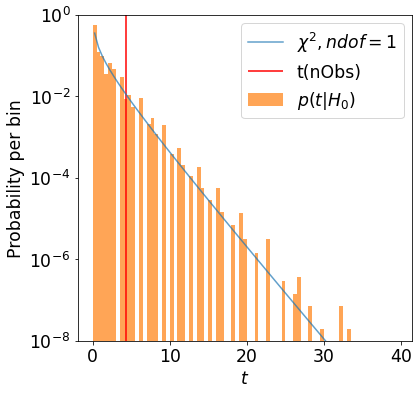

In [7]:
nObs = 30
#nObs = 46 #S for 5 sigma significance 
t_Obs = t(nObs, muBkg, nObs)

ymin = 1E-8
ymax = 1.0
step = bins[1]-bins[0]
x = np.arange(start=bins[0]+step/2.0, stop=bins[-1],step=step)

fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(x,t_H0/np.sum(t_H0), alpha=0.7, color="#ff7f0e", width=step, label = r"$p(t|H_{0})$")
ax.plot(x, chi2.pdf(x, df=1)*step,alpha=0.7,label=r"$\chi^{2}, ndof=1$")
ax.vlines(t_Obs, ymin=ymin, ymax=ymax, color="red", label="t(nObs)")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"Probability per bin")
ax.set_yscale("log")
ax.set_ylim(ymin = ymin, ymax = ymax)
ax.legend();

### Perform hypothesis test for $H_{0}$ - background only, $H_{1}$ - data best fit singal value

Use the modified t test statistics - $q_{0}$

* generate `nEvents=`$100 \cdot 10^{6}$ events with `muBkg=20`, `muSgn=10` assuming $H_{0}$ is true 

In [8]:
muBkg = 20
muSgn = 10
nEvents = int(1E6)
nIter = 100

muData = muBkg
q0_H0 = generate_data_hist(nEvents, nIter, muData, muBkg, bins, q0)

Assume an experiment has observed `nObs=30` events. Calculate probability for $p_{0} = p(q_{0}>q_{0, obs}|H_{0})$, and corrsponding Gaussian `Z` value
using:

* histogram of the $q_{0}$ distribution - a Monte Carlo estimate
* the Gaussian cumulative distribution - an analytical approximation

Next take $\alpha$ corresponding to $5\sigma$, and 

* compare the $p_{0}$ with $\alpha$ and decide if null hypothesis can be rejected.

In [9]:
nObs = 30
#nObs = 46 #S for 5 sigma significance 
q0_Obs = q0(nObs, muBkg, nObs)
#q0_Obs = 25 #q0 for 5sigma exclusion

alpha = 1-norm.cdf(5)
index = np.argwhere(bins>q0_Obs)[0,0]
p_MC = np.sum(q0_H0[index:])/np.sum(q0_H0)
sigma_MC = norm.ppf(1-p_MC)

p_gauss = 1-norm.cdf(np.sqrt(q0_Obs))
sigma_gauss = norm.ppf(1-p_gauss)
isRejected = p_MC<alpha

print(colored("q0_Obs:","blue"),"{:.2f}".format(q0_Obs))
print(colored("MC estimate for p(q0>q0_Obs):","blue"),"{:.2E}".format(p_MC), end=", ")
print(colored("single sided Gaussian sigma:","blue"),"{:.1f}".format(sigma_MC))
print(colored("Gauss esimate for p(q0>q0_Obs):","blue"),"{:.2E}".format(p_gauss), end=", ")
print(colored("single sided Gaussian sigma:","blue"),"{:.1f}".format(sigma_gauss))
print("")
print(colored("alpha:","blue"),"{:.2E}".format(alpha))
print("Null hypothesis (B only) is", end = " ")
if isRejected:
      print(colored("REJECTED","red"))
else:        
    print(colored("NOT REJECTED","green"))

q0_Obs: 4.33
MC estimate for p(q0>q0_Obs): 1.35E-02, single sided Gaussian sigma: 2.2
Gauss esimate for p(q0>q0_Obs): 1.87E-02, single sided Gaussian sigma: 2.1

alpha: 2.87E-07
Null hypothesis (B only) is NOT REJECTED


## Approximate formulas for significance

Plot approximate formulas for signal significance expressed in Gaussian sigmas:

* $\sqrt{q_{0}}$ for Poisson model: $z \simeq \sqrt{2[(S+B)\ln(1 + \frac{S}{B}) - S]}$

* $z \simeq \frac{S}{\sqrt{B}}$

Assume:
* B = 10
* S = [1, 50]

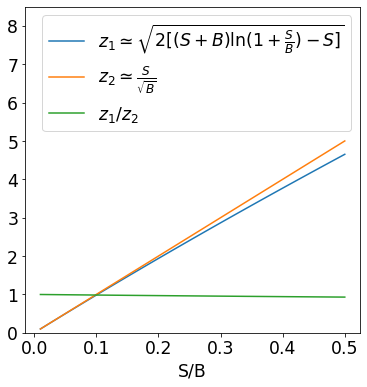

In [10]:
s = np.arange(1,51,1)
b = 100

f1 = np.sqrt(2*((s+b)*np.log(1+s/b) -s))
f2 = s/np.sqrt(b)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(s/100, f1, label=r"$z_{1} \simeq \sqrt{2[(S+B)\ln(1+ \frac{S}{B}) -S]}  $")
ax.plot(s/100, f2, label=r"$z_{2} \simeq \frac{S}{\sqrt{B}}$")
ax.plot(s/100, f1/f2, label=r"$z_{1}/z_{2}$")
ax.set_xlabel("S/B")
ax.set_ylim(ymin = 0, ymax = 8.5)
ax.legend();

## <span style='color:red'> Please: </span> 

Calculate the approximate signal significance with approximate formulas:

* $z \simeq \sqrt{q_{0}}$
* $z \simeq \frac{N_{obs} - B}{\sqrt{B}}$

In [11]:
z_sqrt = np.sqrt(q0_Obs)
z_frac = (nObs - muBkg)/np.sqrt(muBkg)

print(colored("Signficance from sqrt(q0):","blue"),"{:.1f}".format(z_sqrt))
print(colored("Signficance from S/sqrt(B):","blue"),"{:.1f}".format(z_frac))

Signficance from sqrt(q0): 2.1
Signficance from S/sqrt(B): 2.2


## Expected experiment result fluctuations

## <span style='color:red'> Please: </span>

Assuming data is drawn from the alternative hypothesis, (S+B),find:

* $q_{0,median}: \int_{-\infty}^{q_{0,median}} p(q_{0}|H_{1}) dq = 0.5$ 

* $q_{0,minus}: \int_{-\infty}^{q_{0,-}} p(q_{0}|H_{1}) dq = 0.5 - 0.341$ 
* $q_{0,plus}: \int_{-\infty}^{q_{0,+}} p(q_{0}|H_{1}) dq = 0.5 + 0.341$ 
* $q_{0,Asimov}: q0(nObs=S+B)$
* check if probabilities are correct by summing the $q_{0}$ values in corresponding ranges

**Hint:** use histogrammed data created for the $H_{1}$ as approximation

In [12]:
%%time
muBkg = 20
muSgn = 10
muObs = 30

muData = muBkg + muSgn
q0_H1 = generate_data_hist(nEvents, nIter, muData, muBkg, bins, q0)

CPU times: user 15.8 s, sys: 928 ms, total: 16.8 s
Wall time: 16.8 s


In [13]:
cumulative_q0_H1 = np.cumsum(q0_H1)/np.sum(q0_H1)
index_minus = np.argwhere(cumulative_q0_H1>0.5-0.341)[0,0]
index_median = np.argwhere(cumulative_q0_H1>0.5)[0,0]
index_plus = np.argwhere(cumulative_q0_H1>0.5+0.341)[0,0]

q0_minus = x[index_minus]
q0_median = x[index_median]
q0_plus = x[index_plus]

nObs = muBkg + muSgn
q0_Asimov = q0(nObs, muBkg, nObs)
index = np.argwhere(bins>q0_Asimov)[0,0]
p_Asimov = np.sum(q0_H1[index:])/np.sum(q0_H1)
print("q0 median from Asimov dataset = {:.2f}".format(q0_Asimov))
print(colored("MC estimate for p(q0>q0_Asimov) under H1:\t","blue"),"{:.2E} (expected: {:.2f})".format(p_Asimov, 0.5))
print("")

print("q0 minus = {}, q0 median = {}, q0 plus = {}".format(q0_minus, q0_median, q0_plus))
index = np.argwhere(bins>q0_minus)[0,0]
p_MC = np.sum(q0_H1[index:])/np.sum(q0_H1)
print(colored("MC estimate for p(q0>q0_minus) under H1:\t","blue"),"{:.2E} (expected: {:.2f})".format(p_MC, 0.5+0.341))

index = np.argwhere(bins>q0_median)[0,0]
p_MC = np.sum(q0_H1[index:])/np.sum(q0_H1)
print(colored("MC estimate for p(q0>q0_median) under H1:\t","blue"),"{:.2E} (expected: {:.2f})".format(p_MC, 0.5))

index = np.argwhere(bins>q0_plus)[0,0]
p_MC = np.sum(q0_H1[index:])/np.sum(q0_H1)
print(colored("MC estimate for p(q0>q0_plus) under H1: \t","blue"),"{:.2E} (expected: {:.2f})".format(p_MC, 0.5-0.341))

q0 median from Asimov dataset = 4.33
MC estimate for p(q0>q0_Asimov) under H1:	 4.52E-01 (expected: 0.50)

q0 minus = 1.25, q0 median = 4.25, q0 plus = 9.25
MC estimate for p(q0>q0_minus) under H1:	 7.92E-01 (expected: 0.84)
MC estimate for p(q0>q0_median) under H1:	 4.52E-01 (expected: 0.50)
MC estimate for p(q0>q0_plus) under H1: 	 1.57E-01 (expected: 0.16)


## <span style='color:red'> Please: </span>

* plot $q_{0}$ distribution for events drawn under $H_{0}$, and $H_{1}$ hypotheses
* mark the values of $q_{0,minus}$, $q_{0,median}$, $q_{0,plus}$

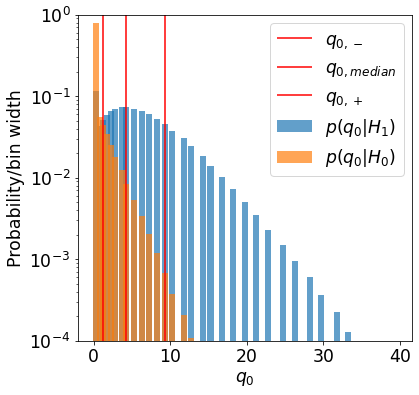

In [14]:
ymin = 1E-4
ymax = 1.0

fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(x,q0_H1/np.sum(q0_H1), alpha=0.7, label = r"$p(q_{0}|H_{1})$")
ax.bar(x,q0_H0/np.sum(q0_H0), alpha=0.7, color="#ff7f0e", label = r"$p(q_{0}|H_{0})$")
ax.vlines(q0_minus, ymin=ymin, ymax=ymax, color="red", label=r"$q_{0,-}$")
ax.vlines(q0_median, ymin=ymin, ymax=ymax, color="red", label=r"$q_{0,median}$")
ax.vlines(q0_plus, ymin=ymin, ymax=ymax, color="red", label=r"$q_{0,+}$")
ax.set_xlabel(r"$q_{0}$")
ax.set_ylabel(r"Probability/bin width")
ax.set_yscale("log")
ax.set_ylim(ymin = ymin, ymax = ymax)
ax.legend();

* calculate the $p_{0}$ and $Z$ values for $q_{0,minus}$, $q_{0,median}$, $q_{0,plus}$ and $q_{0,Asimov}$
* note the difference of $Z$ values for choosed $q_{0}$ values

In [15]:
p = 1 - norm.cdf(np.sqrt(q0_minus))
sigma = norm.ppf(1-p)

print(colored("Gauss esimate for p(q0>q0_minus):\t","blue"),"{:.2E},\t".format(p), end = "")
print(colored("single sided Gaussian sigma:","blue"),"{:.1f}".format(sigma))

p = 1 - norm.cdf(np.sqrt(q0_median))
sigma = norm.ppf(1-p)
print(colored("Gauss esimate for p(q0>q0_median):\t","blue"),"{:.2E},\t".format(p), end = "")
print(colored("single sided Gaussian sigma:","blue"),"{:.1f}".format(sigma))

p = 1 - norm.cdf(np.sqrt(q0_Asimov))
sigma = norm.ppf(1-p)
print(colored("Gauss esimate for p(q0>q0_Asimov):\t","green"),"{:.2E},\t".format(p), end = "")
print(colored("single sided Gaussian sigma:","green"),"{:.1f}".format(sigma))

p = 1 - norm.cdf(np.sqrt(q0_plus))
sigma = norm.ppf(1-p)
print(colored("Gauss esimate for p(q0>q0_plus):\t","blue"),"{:.2E},\t".format(p), end = "")
print(colored("single sided Gaussian sigma:","blue"),"{:.1f}".format(sigma))

Gauss esimate for p(q0>q0_minus):	 1.32E-01,	single sided Gaussian sigma: 1.1
Gauss esimate for p(q0>q0_median):	 1.96E-02,	single sided Gaussian sigma: 2.1
Gauss esimate for p(q0>q0_Asimov):	 1.87E-02,	single sided Gaussian sigma: 2.1
Gauss esimate for p(q0>q0_plus):	 1.18E-03,	single sided Gaussian sigma: 3.0


## Homework - Perform hypothesis test for $H_{0}$ - the expected signal value, $H_{1}$ - data best fit singal value

Assume there is an experiment planned, where one expects to observe `muBkg=200` background events. what value of additional signal events, `muSgn` can be exluded with $\alpha = 0.05$?

* define `qMu(data, mu_H0, mu_H1)` function for the $q_{\mu}$ test statistics
* scan a range of assumed `muSgn` values:
    * for each value calculate median $q_{0}$ value as the Asimov $q_{0,Asimov}$
    * using the Gaussian cumulative distribution caluculate $p_{0}(q_{0}>q_{0,Asimov})$
    * return minimal value of `muSgn` for which $p_{0}<\alpha$

In [16]:
##########################
def qMu(data, mu_H0, mu_H1):
    result = -2.0*(np.log(poisson.pmf(data, mu_H0)) - np.log(poisson.pmf(data, mu_H1)))
    result = np.where(data>mu_H0, 0, result)
    return result
###########################
###########################
def getPValue(data, mu_H0, mu_H1):
    qMu_Asimov = qMu(data=data, mu_H0=mu_H0, mu_H1=data)
    p = 1 - norm.cdf(np.sqrt(qMu_Asimov))
    return p
###########################
def isExcluded(data, mu_H0, alpha):
    return getPValue(data=data, mu_H0=mu_H0, mu_H1=data)<alpha
###########################
def exclusionBand(muBkg, alpha):

    muSgn = np.arange(1, muBkg, 1).astype(int)

    excluded = []
    for nObs in np.random.poisson(lam=muBkg, size=1000):
        mu_H0 = muSgn+muBkg
        index = np.argmax(isExcluded(nObs, mu_H0, alpha))
        excluded.append(muSgn[index])  
           
    counts, bins = np.histogram(excluded, bins=muSgn)    
    cumulative_q0_H1 = np.cumsum(counts)/np.sum(counts)
    
    index_minus2 = np.argwhere(cumulative_q0_H1>0.5-0.341-0.136)[0,0]
    index_minus1 = np.argwhere(cumulative_q0_H1>0.5-0.341)[0,0]
    index_median = np.argwhere(cumulative_q0_H1>0.5)[0,0]
    index_plus1 = np.argwhere(cumulative_q0_H1>0.5+0.341)[0,0]
    index_plus2 = np.argwhere(cumulative_q0_H1>0.5+0.341+0.136)[0,0]
    
    if np.abs(B-200)<1:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.hist(excluded, bins=muSgn)
        ax.set_xlabel(r"95% CLupper limit on S")
  
    q0_minus2 = bins[index_minus2]
    q0_minus1 = bins[index_minus1]
    q0_median = bins[index_median]
    q0_plus1 = bins[index_plus1]
    q0_plus2 = bins[index_plus2]
    return q0_minus2, q0_minus1, q0_median, q0_plus1, q0_plus2
########################### 
def expectedBkg(m):
    return 200*np.exp(-(m-100)/20)
###########################

## Expected median exclusion limit

In [17]:
muBkg = 200
muSgn = np.arange(1, muBkg, 1).astype(int)
alpha = 0.05

data = muBkg
mu_H0 = muSgn+muBkg
index = np.argmax(isExcluded(data, mu_H0, alpha))
S_excluded = muSgn[index]
print(colored("Expectded median exclusion on S","blue"),"= {}".format(S_excluded))

Expectded median exclusion on S = 25


## Expected median and $\pm 1 \sigma$ exlusion limits for varying expected number of background events.

The exclusion limits are calculated with toy Monte Carlo.

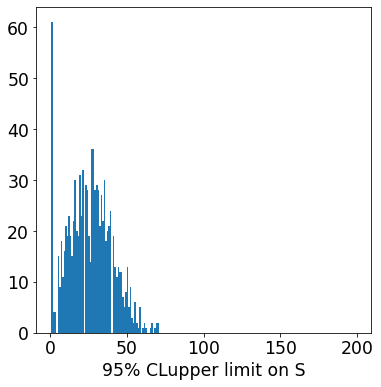

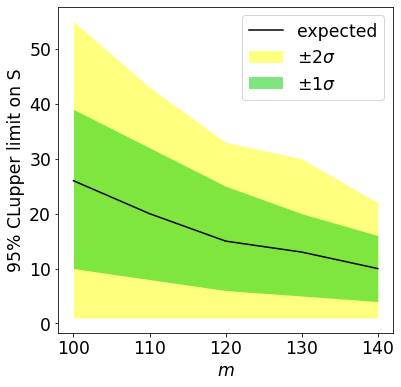

In [18]:
alpha = 0.05
m = np.arange(100,150,10)
muBkg = expectedBkg(m)

q0_minus2 = []
q0_minus1 = []
q0_median = []
q0_plus1 = []
q0_plus2 = []

for B in muBkg:
    minus2, minus1, median, plus1, plus2 = exclusionBand(B, alpha)
    q0_minus2.append(minus2)
    q0_minus1.append(minus1)
    q0_median.append(median)
    q0_plus1.append(plus1)
    q0_plus2.append(plus2)
    
fig, ax = plt.subplots(figsize=(6, 6))
ax.fill_between(m, q0_plus2, q0_minus2, color ="#ffff00", alpha=.5, linewidth=0, label=r"$\pm2 \sigma$")
ax.fill_between(m, q0_plus1, q0_minus1, color ="#00cc00", alpha=.5, linewidth=0, label=r"$\pm1 \sigma$")
ax.plot(m, q0_median, color="black", label="expected")
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"95% CLupper limit on S")
ax.legend();    

$\pm 1 \sigma$ exclusions limits calculated from asymptotic formulas

In [19]:
muBkg = 200
muSgn = 25 #Need some S value for asymptotic formula
alpha = 0.05

qMu_Asimov = qMu(muBkg, muSgn+muBkg, muBkg)
sigma = muSgn/np.sqrt(qMu_Asimov)
excluded_median = sigma*norm.ppf(1-alpha)
excluded_minus = sigma*(norm.ppf(1-alpha) - 1)
excluded_plus = sigma*(norm.ppf(1-alpha) + 1)
print(colored("asymptotic 95% UL:","blue"), "{:2.0f} -  {:2.0f} - {:2.0f}".format(excluded_minus,excluded_median, excluded_plus))

minus2, minus1, median, plus1, plus2 = exclusionBand(muBkg, alpha)    
print(colored("toy MC 95% UL:","blue"), "{:2.0f} -  {:2.0f} - {:2.0f}".format(minus1,median, plus1))

asymptotic 95% UL:  9 -  24 - 39
toy MC 95% UL:  9 -  24 - 39
